In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
import itertools
from scipy.stats import kstest  # Kolmogorov_Smirnov test for adjusment to a given distribution
import seaborn as sns

## Experiment 1: gatekeeper test for Tile Size (in order to prove that it's not a significant factor)

In [3]:
data = pd.read_csv('RESULTS_EGDGIDAF_CumCondCount=2_2024-01-17.csv')
data.head()

,Tile.Size,Prev.Length,Match.Score,Prev.Type,Browse.Time
0,0.1,75,95,TT,13.879664
1,0.5,75,95,TT,13.920113
2,0.1,75,95,TT,14.483337
3,0.5,75,95,TT,14.547307
4,0.1,75,95,TT,14.937853


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tile.Size    200 non-null    float64
 1   Prev.Length  200 non-null    int64  
 2   Match.Score  200 non-null    int64  
 3   Prev.Type    200 non-null    object 
 4   Browse.Time  200 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 7.9+ KB


In [5]:
for col in data.columns[:-1]:
    print(f"{col} has {data[col].nunique()} level(s): {data[col].unique()}")

Tile.Size has 2 level(s): [0.1 0.5]
Prev.Length has 1 level(s): [75]
Match.Score has 1 level(s): [95]
Prev.Type has 1 level(s): ['TT']


In [6]:
condition_1 = data.loc[data['Tile.Size']==0.1, 'Browse.Time']
condition_2 = data.loc[data['Tile.Size']==0.5, 'Browse.Time']

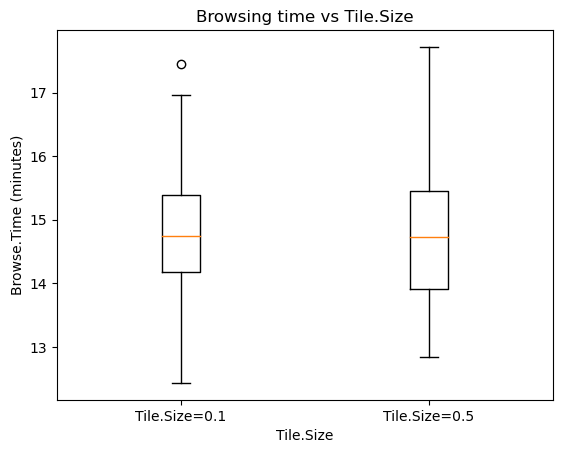

In [7]:
conditions = [condition_1, condition_2]
plt.boxplot(conditions, labels = ["Tile.Size=0.1", "Tile.Size=0.5"]);
plt.ylabel("Browse.Time (minutes)");
plt.xlabel("Tile.Size")
plt.title("Browsing time vs Tile.Size");

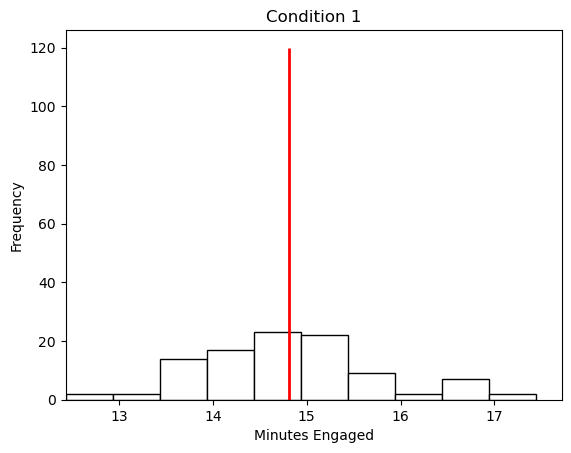

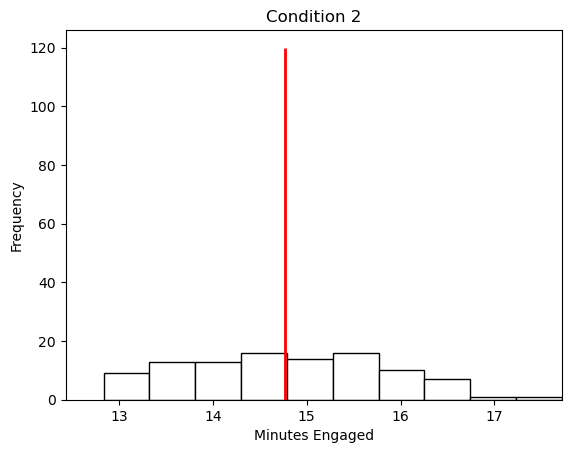

In [8]:
xmin = min(min(condition_1), min(condition_2))
xmax = max(max(condition_1), max(condition_2))

plt.figure()
plt.hist(condition_1, color = "white", edgecolor = "black")
plt.xlim(xmin,xmax)
plt.xlabel("Minutes Engaged")
plt.ylabel("Frequency")
plt.title("Condition 1")
plt.vlines(x = np.mean(condition_1), ymin = 0, ymax = 120, color = "red", linewidth = 2)

plt.figure()
plt.hist(condition_2, color = "white", edgecolor = "black")
plt.xlim(xmin,xmax)
plt.xlabel("Minutes Engaged")
plt.ylabel("Frequency")
plt.title("Condition 2")
plt.vlines(x = np.mean(condition_2), ymin = 0, ymax = 120, color = "red", linewidth = 2)

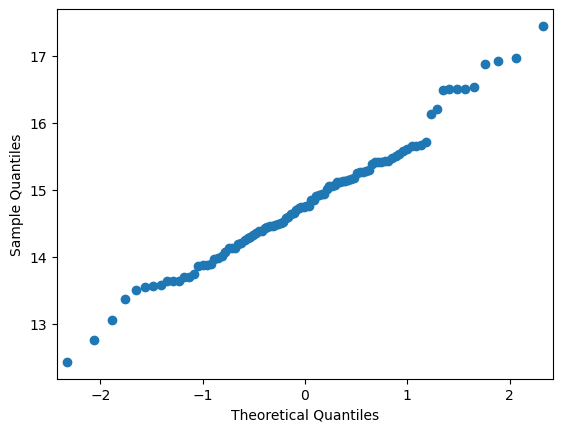

In [9]:
sm.qqplot(condition_1);

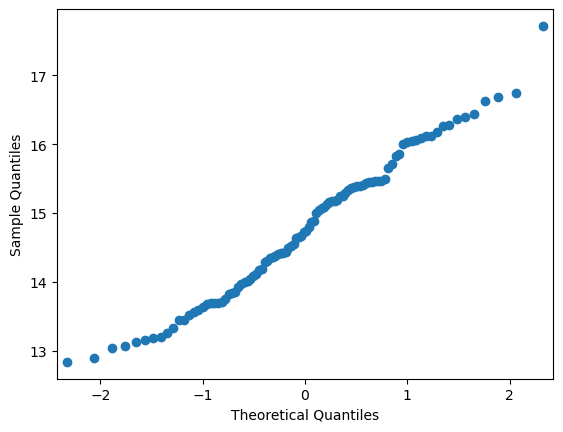

In [10]:
sm.qqplot(condition_2);

In [11]:
# The KS test with 'norm' argument compares a distribution to the N(0,1) distribution,
# so we first need to standardize out data to perform the test.
# H0 is normality, H1 is non-normality
condition_1_std = (condition_1-np.mean(condition_1))/np.std(condition_1)
condition_2_std = (condition_2-np.mean(condition_2))/np.std(condition_2)

In [12]:
kstest(condition_1_std, 'norm')

KstestResult(statistic=0.059757810031699776, pvalue=0.8462830268986626, statistic_location=0.9162884580905043, statistic_sign=1)

Fail to reject H0, meaning there is not enough evidence to reject the normality assumption. Therefore, I conclude that the data in condition_1 is normally distributed.

In [13]:
kstest(condition_2_std, 'norm')

KstestResult(statistic=0.0582612311968847, pvalue=0.8666058985995625, statistic_location=-0.871506721205815, statistic_sign=1)

Same conclusion for condition_2.

Let's first perform the test that compares variances in the 2 conditions.

In [14]:
t = np.var(condition_1, ddof=1)/np.var(condition_2, ddof=1)
print("t =", t)

t = 0.8006519820710166


In [15]:
pv = stats.f.cdf(t, dfn=99, dfd=99) + 1 - stats.f.cdf(1/t, dfn=99, dfd=99)
print("p-value =", pv)

p-value = 0.2703953056947396


I reject H0, suggesting that there's a significant difference between the variances of the 2 conditions. So I'll use Welch's test instead of the Student's t-test.

In [16]:
t, pv = stats.ttest_ind(condition_1, condition_2, equal_var=False, alternative='two-sided')  # we assume that the samples under H0 and H1 are independent
print("t =", t)
print("p-value =", pv)

t = 0.29282071198014764
p-value = 0.7699695929109459


I fail to reject H0, suggesting that the ABT in condition 1 is not significantly different from the ABT in condition_2. Therefore, I conclude that the main effect of Tile.Size is not significant for the ABT, which is what I wanted to show.

Note: since there are only 2 conditions, the t-test performed above is actually equivalent to the global F-test in the linear regression of browse_time vs tile_size. We can check this below:

In [18]:
model = smf.ols('browse_time ~ tile_size', data=data.rename(columns={'Tile.Size':'tile_size', 'Browse.Time': "browse_time"})).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            browse_time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.08574
Date:                Wed, 17 Jan 2024   Prob (F-statistic):              0.770
Time:                        20:38:19   Log-Likelihood:                -283.02
No. Observations:                 200   AIC:                             570.0
Df Residuals:                     198   BIC:                             576.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.8204      0.128    116.126      0.000      14.569      15.072
tile_size     -0.1036      0.354     -0.293      0.770      -0.802       0.594
==============================================================================
Omnibus:                        2.636   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.268   Jarque-Bera (JB):                2.670
Skew:                           0.245   Prob(JB):                        0.263
Kurtosis:                       2.718   Cond. No.                         5.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Even though the test statistic are not the same (the one in the global F-test is the square of the one in the t-test), the p-values are indeed the same (0.547), confirming the previous result.

## Draft part 2: factor screening through a 2^3 factorial experiment (before lecture 7)

In [19]:
data = pd.read_csv('Minimal_fact_expt.csv')\
    .rename(columns={'Tile.Size':'tile_size', 'Browse.Time': "browse_time", "Match.Score": "match_score", "Prev.Length": 'prev_length', "Prev.Type": "prev_type"})
data.head(10)

FileNotFoundError: [Errno 2] No such file or directory: 'Minimal_fact_expt.csv'

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   prev_length  800 non-null    int64  
 1   match_score  800 non-null    int64  
 2   prev_type    800 non-null    object 
 3   tile_size    800 non-null    float64
 4   browse_time  800 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 31.4+ KB


In [ ]:
for col in data.columns[:-1]:
    print(f"{col} has {data[col].nunique()} level(s): {data[col].unique()}")

prev_length has 2 level(s): [75 30]
match_score has 2 level(s): [95 50]
prev_type has 2 level(s): ['TT' 'AC']
tile_size has 1 level(s): [0.2]


Let's start by studying the interactions between the factors.

### 3-factor interaction effect

In [ ]:
model = smf.ols('browse_time ~ prev_length * match_score * C(prev_type)', data=data).fit()  # full model, i.e., with main effect and interaction effect terms
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            browse_time   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     911.6
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        16:51:46   Log-Likelihood:                -1138.0
No. Observations:                 800   AIC:                             2292.
Df Residuals:                     792   BIC:                             2329.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     31.3859      0.432     72.665      0.000      30.538      32.234
C(prev_type)[T.TT]                            -4.5644      0.611     -7.472      0.000      -5.763      -3.365
prev_length                                   -0.1121      0.008    -14.826      0.000      -0.127      -0.097
prev_length:C(prev_type)[T.TT]                -0.0020      0.011     -0.188      0.851      -0.023       0.019
match_score                                   -0.0671      0.006    -11.785      0.000      -0.078      -0.056
match_score:C(prev_type)[T.TT]                -0.0047      0.008     -0.579      0.563      -0.020       0.011
prev_length:match_score                        0.0007   9.96e-05      7.450      0.000       0.001       0.001
prev_length:match_score:C(prev_type)[T.TT]  4.506e-05      0.000      0.320      0.749      -0.000       0.000
==============================================================================
Omnibus:                        5.204   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                6.144
Skew:                          -0.077   Prob(JB):                       0.0463
Kurtosis:                       3.401   Cond. No.                     9.73e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let's compare this full model (main effects, 2FI interactions effect, 3FI interactions effect) to the model that has everything except the 3 FI interaction effect.

In [ ]:
model_red_1 = smf.ols('browse_time ~\
                  prev_length + match_score + C(prev_type)\
                  + prev_length : match_score + prev_length: C(prev_type) + match_score: C(prev_type)',\
                    data=data).fit()

In [ ]:
sm.stats.anova_lm(model_red_1, model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,793.0,805.802045,0.0,NaN,NaN,NaN
1,792.0,805.697974,1.0,0.104071,0.102302,0.749169


The p-value is very large, so we fail to reject H0. This suggests that there's not a significant 3-factor interaction effect on the target. Therefore, in the following experiments, I don't need to include this interaction.

### 2-factor interaction effect

Let's now test the significance of each 2FI interaction effect.

But first, let's try to build our intuition using interaction effect plots.

#### Plots: create a function to automate

First, let's plot the interaction effect between Match.Score and Prev.Length.

In [ ]:
# def create_2_FI_plot(factor_1: str, factor_2: str, factor_1_levels: list, factor_2_levels: list):
#     y_1 = data.loc[(data[factor_1]==factor_1_levels[0]) & (data[factor_2]==factor_2_levels[0]), 'browse_time'].mean()
#     y_2 = data.loc[(data[factor_1]==factor_1_levels[0]) & (data[factor_2]==factor_2_levels[1]), 'browse_time'].mean()
#     y_3 = data.loc[(data[factor_1]==factor_1_levels[1]) & (data[factor_2]==factor_2_levels[0]), 'browse_time'].mean()
#     y_4 = data.loc[(data[factor_1]==factor_1_levels[1]) & (data[factor_2]==factor_2_levels[1]), 'browse_time'].mean()

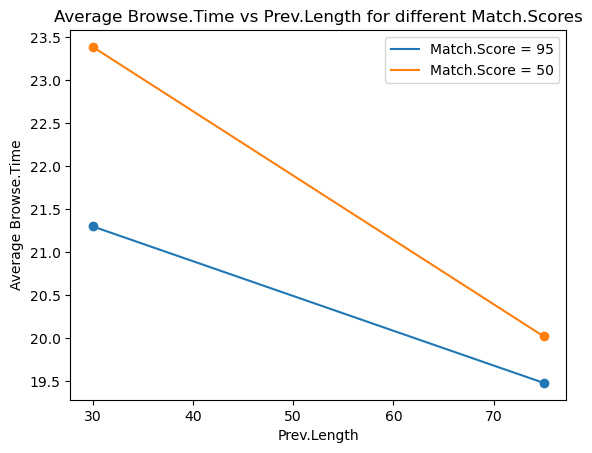

In [ ]:
y_1 = data.loc[(data['prev_length']==30) & (data['match_score']==95), 'browse_time'].mean()
y_2 = data.loc[(data['prev_length']==30) & (data['match_score']==50), 'browse_time'].mean()
y_3 = data.loc[(data['prev_length']==75) & (data['match_score']==95), 'browse_time'].mean()
y_4 = data.loc[(data['prev_length']==75) & (data['match_score']==50), 'browse_time'].mean()

plt.figure()

# Match_score = 95
plt.scatter([30,75], [y_1, y_3])
plt.plot([30,75], [y_1, y_3], label='Match.Score = 95')

# Match_score = 50
plt.scatter([30,75], [y_2, y_4])
plt.plot([30,75], [y_2, y_4], label='Match.Score = 50', linestyle='-')


plt.xlabel('Prev.Length')
plt.ylabel('Average Browse.Time')
plt.title('Average Browse.Time vs Prev.Length for different Match.Scores')
plt.legend()
plt.show()

In [ ]:
data.head()

,prev_length,match_score,prev_type,tile_size,browse_time
0,75,95,TT,0.2,18.088445
1,75,95,AC,0.2,21.633264
2,75,50,TT,0.2,18.872404
3,75,50,AC,0.2,22.887871
4,30,95,TT,0.2,19.866048


In [ ]:
means = data.groupby(['match_score', 'prev_length'])['browse_time'].mean()
means

match_score  prev_length
50           30             23.387956
             75             20.018062
95           30             21.298002
             75             19.476469
Name: browse_time, dtype: float64

In [ ]:
means.iloc[0]

23.387956045388854

Since the 2 segments are not parallel, it's likely that there's an interaction effect between Match.Score and Prev.Length. We'll test this more formally below. However, at this point, we can already say that the pattern is the same, no matter if the Match.Score is 95 or 60: a prev_length of 75 is associated with a lower average browsing time than a prev_length of 30.

Careful, this doesn't mean that the longer the preview, the lower the average browsing time. Indeed, we have only 2 data points, and it's highly possible that the minimum would sit in between those 2 values.

Next, let's do the same with Match.Score and Prev.Type.

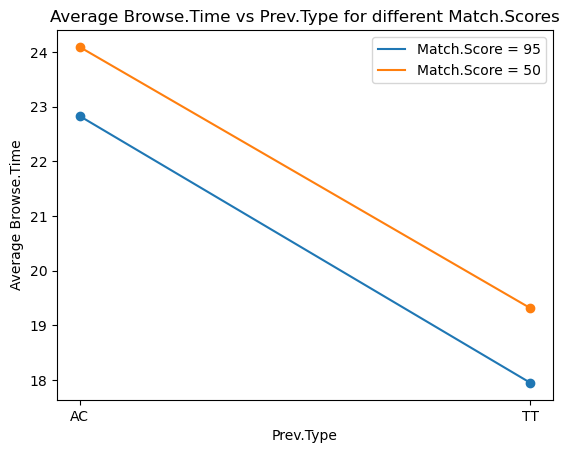

In [ ]:
y_1 = data.loc[(data['prev_type']=='AC') & (data['match_score']==95), 'browse_time'].mean()
y_2 = data.loc[(data['prev_type']=='AC') & (data['match_score']==50), 'browse_time'].mean()
y_3 = data.loc[(data['prev_type']=='TT') & (data['match_score']==95), 'browse_time'].mean()
y_4 = data.loc[(data['prev_type']=='TT') & (data['match_score']==50), 'browse_time'].mean()

plt.figure()

# Match_score = 95
plt.scatter(['AC', 'TT'], [y_1, y_3])
plt.plot(['AC', 'TT'], [y_1, y_3], label='Match.Score = 95')

# Match_score = 50
plt.scatter(['AC', 'TT'], [y_2, y_4])
plt.plot(['AC', 'TT'], [y_2, y_4], label='Match.Score = 50')


plt.xlabel('Prev.Type')
plt.ylabel('Average Browse.Time')
plt.title('Average Browse.Time vs Prev.Type for different Match.Scores')
plt.legend()
plt.show()

Since the 2 segments are perfectly parallel, we conclude that there's probably no interaction effect between Match.Score and Prev.Type. In other words, the effect of Prev.Type on Browse.Time doesn't depend on the level of Match.Score. Again, I'll check this formally using a test.

Finally, let's do the same with Prev.Length and Prev.Type.

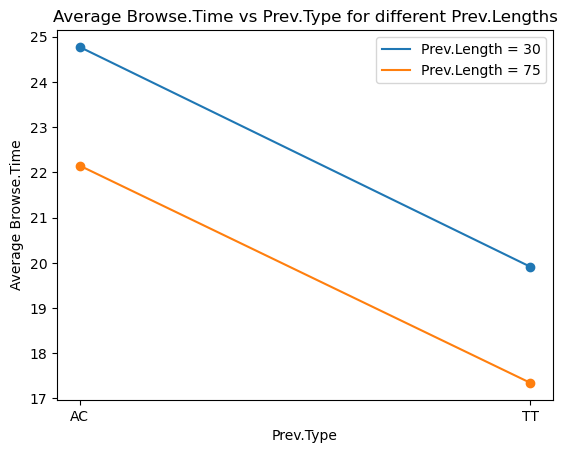

In [ ]:
y_1 = data.loc[(data['prev_type']=='AC') & (data['prev_length']==30), 'browse_time'].mean()
y_2 = data.loc[(data['prev_type']=='AC') & (data['prev_length']==75), 'browse_time'].mean()
y_3 = data.loc[(data['prev_type']=='TT') & (data['prev_length']==30), 'browse_time'].mean()
y_4 = data.loc[(data['prev_type']=='TT') & (data['prev_length']==75), 'browse_time'].mean()

plt.figure()

# Match_score = 95
plt.scatter(['AC', 'TT'], [y_1, y_3])
plt.plot(['AC', 'TT'], [y_1, y_3], label='Prev.Length = 30')

# Match_score = 50
plt.scatter(['AC', 'TT'], [y_2, y_4])
plt.plot(['AC', 'TT'], [y_2, y_4], label='Prev.Length = 75')


plt.xlabel('Prev.Type')
plt.ylabel('Average Browse.Time')
plt.title('Average Browse.Time vs Prev.Type for different Prev.Lengths')
plt.legend()
plt.show()

Since the 2 segments are perfectly parallel, we conclude that there's probably no interaction effect between Prev.Length and Prev.Type. In other words, the effect of Prev.Length on Browse.Time doesn't depend on the level of Prev.Type.

#### Tests

In [ ]:
# model without the prev_length : match_score interaction
model_red_2 = smf.ols('browse_time ~\
                  prev_length + match_score + C(prev_type)\
                  + match_score: C(prev_type) + prev_length: C(prev_type)',\
                    data=data).fit()

In [ ]:
sm.stats.anova_lm(model_red_2, model_red_1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,794.0,925.673142,0.0,NaN,NaN,NaN
1,793.0,805.802045,1.0,119.871097,117.966665,1.026889e-25


The p-value of the partial F-test is almost null. Therefore, I conclude that there's a significant interaction effect between Prev.Length and Match.Score, which confirms my intuition from the plot.

In [ ]:
# model without the match_score: C(prev_type) interaction
model_red_3 = smf.ols('browse_time ~\
                  prev_length + match_score + C(prev_type)\
                  + prev_length : match_score + prev_length: C(prev_type)',\
                    data=data).fit()

In [ ]:
sm.stats.anova_lm(model_red_3, model_red_1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,794.0,806.333023,0.0,NaN,NaN,NaN
1,793.0,805.802045,1.0,0.530978,0.522542,0.469972


The p-value of the partial F-test is very large (>> 5%). Therefore, I conclude that there's no significant interaction effect between Prev.Type and Match.Score, which confirms my intuition from the plot.

In [ ]:
# model without the prev_length: C(prev_type) interaction
model_red_4 = smf.ols('browse_time ~\
                  prev_length + match_score + C(prev_type)\
                  + prev_length : match_score + match_score: C(prev_type)',\
                    data=data).fit()

In [ ]:
sm.stats.anova_lm(model_red_4, model_red_1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,794.0,805.961890,0.0,NaN,NaN,NaN
1,793.0,805.802045,1.0,0.159845,0.157306,0.691756


The p-value of the partial F-test is very large (>> 5%). Therefore, I conclude that there's no significant interaction effect between Prev.Type and Prev.Length, which confirms my intuition from the plot.

So far, we've found that out of the 4 possible factor interactions effects (2 and 3), only one is significant: prev_length : match_score. Therefore, the model I'm going to be using next is the one with every individual factor, and only one interaction: prev_length : match_score.

Other observations that will be useful for the part where we'll search for the optimum:
- Whether Match.Score is 95 of 50, the average browsing time is lower with the default value of Prev.Length (75) than when it's 30.


### Main effect

Careful here, since there's a significant interaction effect between Match.Score and Prev.Length, it doesn't make sense to look at their individual main effect plots nor their individual partial F-tests. However, since the Prev.Type has no significant interaction with any of the other two factors, we can study its main effect on its own.

#### Plot

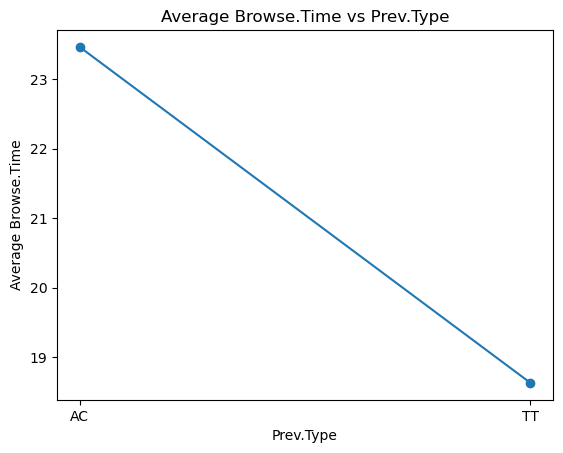

In [ ]:
y_1 = data.loc[data['prev_type']=='AC', 'browse_time'].mean()
y_2 = data.loc[data['prev_type']=='TT', 'browse_time'].mean()

plt.figure()
plt.scatter(['AC', 'TT'], [y_1, y_2])
plt.plot(['AC', 'TT'], [y_1, y_2])

plt.xlabel('Prev.Type')
plt.ylabel('Average Browse.Time')
plt.title('Average Browse.Time vs Prev.Type')
plt.show()

Prev.Type seems to have an effect on the average browsing time. Specifically, TT seems to be associated with a lower average browsing time. Let's check if this difference is significant using a partial F-test.

#### Test

In [ ]:
# best model so far
model_red_5 = smf.ols('browse_time ~\
                  prev_length + match_score + C(prev_type)\
                  + prev_length : match_score',\
                    data=data).fit()

In [ ]:
# previous model without C(prev_type)
model_red_6 = smf.ols('browse_time ~\
                  prev_length + match_score\
                  + prev_length : match_score',\
                    data=data).fit()

In [ ]:
sm.stats.anova_lm(model_red_6, model_red_5)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,796.0,5483.906667,0.0,NaN,NaN,NaN
1,795.0,806.492868,1.0,4677.413799,4610.758654,0.0


Can conclude that Prev.Type has a significant effect on the average browsing time, which confirms the previous plot.

Can quantify this effect using by interpreting the coefficient corresponding to the Prev.Type.

In [ ]:
model_red_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            browse_time   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     1600.
Date:                Mon, 15 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:04:02   Log-Likelihood:                -1138.4
No. Observations:                 800   AIC:                             2287.
Df Residuals:                     795   BIC:                             2310.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  31.5217      0.307    102.655      0.000      30.919      32.124
C(prev_type)[T.TT]         -4.8360      0.071    -67.903      0.000      -4.976      -4.696
prev_length                -0.1131      0.005    -21.185      0.000      -0.124      -0.103
match_score                -0.0694      0.004    -17.269      0.000      -0.077      -0.061
prev_length:match_score     0.0008   7.03e-05     10.870      0.000       0.001       0.001
==============================================================================
Omnibus:                        5.082   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                5.961
Skew:                          -0.077   Prob(JB):                       0.0508
Kurtosis:                       3.394   Cond. No.                     3.74e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Interpretations of the coefficients:
- The average browsing time when preview type is TT is -4.8 seconds lower than the average browsing time when preview type is AC. This tells us that TT seems to be better in order to minimize browsing time. In other words, in part 3, we'll tend to choose TT for the prev_type, no need to use AC in the exp conditions.
- Remember, for the 2 other factors (match score and prev_length), the test and interpretation of main effects are not appropriate, because we need to take into account interaction between those 2 factors.

## Final part 2: screening phase through a 2^3 factorial experiment

In [17]:
def generate_file_for_app(PL_levels, PT_levels, MS_levels, output_filename):
    # Generate all possible experimental conditions
    all_combinations = list(itertools.product(PL_levels, PT_levels, MS_levels))

    # Create a DataFrame
    df = pd.DataFrame(all_combinations, columns=['Prev.Length', 'Prev.Type', 'Match.Score'])

    # Print the DataFrame
    print(df)

    # Export the DataFrame to a CSV file
    df.to_csv(f'{output_filename}', index=False)

    return df

In [18]:
PL_levels = [30, 120]
PT_levels = ['TT', 'AC']
MS_levels = [0, 100]

In [19]:
df = generate_file_for_app(PL_levels, PT_levels, MS_levels, 'EGDGIDAF.csv')

   Prev.Length Prev.Type  Match.Score
0           30        TT            0
1           30        TT          100
2           30        AC            0
3           30        AC          100
4          120        TT            0
5          120        TT          100
6          120        AC            0
7          120        AC          100


In [20]:
# sanity check
for col in df.columns:
    print(f"{col} has {df[col].nunique()} level(s): {df[col].unique()}")

Prev.Length has 2 level(s): [ 30 120]
Prev.Type has 2 level(s): ['TT' 'AC']
Match.Score has 2 level(s): [  0 100]


In [21]:
data = pd.read_csv('RESULTS_EGDGIDAF_CumCondCount=10_2024-01-17.csv')\
    .rename(columns={'Tile.Size':'tile_size', 'Browse.Time': "browse_time", "Match.Score": "match_score", "Prev.Length": 'prev_length', "Prev.Type": "prev_type"})
data.head()

,prev_length,prev_type,match_score,tile_size,browse_time
0,30,TT,0,0.2,18.267803
1,30,TT,100,0.2,17.770616
2,30,AC,0,0.2,26.610336
3,30,AC,100,0.2,21.814909
4,120,TT,0,0.2,20.857324


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   prev_length  800 non-null    int64  
 1   prev_type    800 non-null    object 
 2   match_score  800 non-null    int64  
 3   tile_size    800 non-null    float64
 4   browse_time  800 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 31.4+ KB


In [23]:
# sanity check
assert len(data) == 800

In [24]:
# sanity check
for col in data.columns[:-1]:
    print(f"{col} has {data[col].nunique()} level(s): {data[col].unique()}")

prev_length has 2 level(s): [ 30 120]
prev_type has 2 level(s): ['TT' 'AC']
match_score has 2 level(s): [  0 100]
tile_size has 1 level(s): [0.2]


Fit the full model with all main effects and interaction terms

In [26]:
model = smf.ols('browse_time ~ prev_length * match_score * C(prev_type)', data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            browse_time   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     1037.
Date:                Thu, 18 Jan 2024   Prob (F-statistic):               0.00
Time:                        08:22:06   Log-Likelihood:                -1090.2
No. Observations:                 800   AIC:                             2196.
Df Residuals:                     792   BIC:                             2234.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     24.8760      0.131    190.496      0.000      24.620      25.132
C(prev_type)[T.TT]                            -5.0785      0.185    -27.500      0.000      -5.441      -4.716
prev_length                                    0.0012      0.001      0.774      0.439      -0.002       0.004
prev_length:C(prev_type)[T.TT]                -0.0009      0.002     -0.444      0.657      -0.005       0.003
match_score                                   -0.0417      0.002    -22.575      0.000      -0.045      -0.038
match_score:C(prev_type)[T.TT]                 0.0006      0.003      0.214      0.830      -0.005       0.006
prev_length:match_score                        0.0003   2.11e-05     16.064      0.000       0.000       0.000
prev_length:match_score:C(prev_type)[T.TT]  2.455e-05   2.99e-05      0.822      0.411   -3.41e-05    8.32e-05
==============================================================================
Omnibus:                        1.069   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.586   Jarque-Bera (JB):                1.135
Skew:                           0.084   Prob(JB):                        0.567
Kurtosis:                       2.925   Cond. No.                     4.45e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From this summary table, we can see that the only significant interaction is the one between Preview Length and Match Score; all others all not.

In order to confirm this, let's compare the full model to a reduced model with just and the main effects and interactions that appear to be significant in the previous table.

In [27]:
model_red = smf.ols('browse_time ~ prev_length + match_score + C(prev_type) + prev_length : match_score', data=data).fit()

In [28]:
sm.stats.anova_lm(model_red, model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,795.0,718.531630,0.0,NaN,NaN,NaN
1,792.0,715.005341,3.0,3.526288,1.302004,0.272593


Fail to reject H0, suggesting that the full model is not significantly better than the reduced model. This confirms that the 3 FI effect as well as the 2 FI between Preview Length and Preview Type and Match Score and Preview Type are not significant.

Lets next look at main and interaction effect plots for additional insight into these findings.

In [29]:
condition_1 = data.loc[data['prev_length']==30, 'browse_time']
condition_2 = data.loc[data['prev_length']==120, 'browse_time']

In [30]:
len(condition_1)

400

In [31]:
t = np.var(condition_1, ddof=1)/np.var(condition_2, ddof=1)
print("t =", t)

t = 1.3645794685768915


In [32]:
pv = stats.f.cdf(1/t, dfn=399, dfd=399) + 1 - stats.f.cdf(t, dfn=399, dfd=399)
print("p-value =", pv)

p-value = 0.001958711858864315


In [33]:
t, pv = stats.ttest_ind(condition_1, condition_2, equal_var=False, alternative='two-sided')  # we assume that the samples under H0 and H1 are independent
print("t =", t)
print("p-value =", pv)

t = -8.002719041036173
p-value = 4.4070546195906045e-15


Average Browse.Time vs Prev.Length for different Match.Scores

Text(0.5, 1.0, 'Average Browsing Time vs Preview Length')

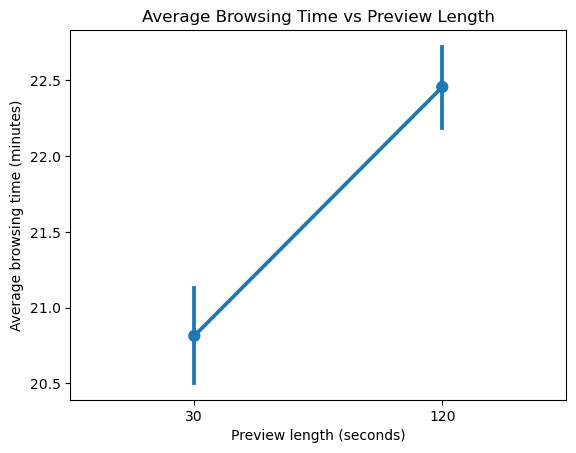

In [34]:
# Main effect of prev_length
#sns.set_theme(style="darkgrid")
fig1 = sns.pointplot(x="prev_length", y="browse_time", data=data)
fig1.set_ylabel("Average browsing time (minutes)")
fig1.set_xlabel("Preview length (seconds)")
plt.title("Average Browsing Time vs Preview Length")

Text(0.5, 1.0, 'Average Browsing Time vs Preview Type')

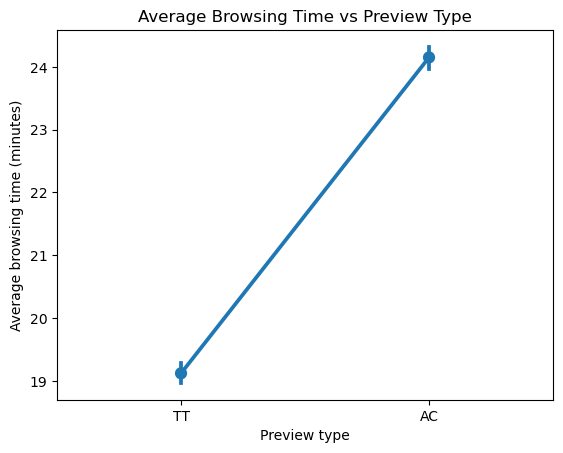

In [35]:
# Main effect of prev_type
#sns.set_theme(style="darkgrid")
fig1 = sns.pointplot(x="prev_type", y="browse_time", data=data)
fig1.set_ylabel("Average browsing time (minutes)")
fig1.set_xlabel("Preview type")
plt.title("Average Browsing Time vs Preview Type")

Text(0.5, 1.0, 'Average Browsing Time vs Match Score')

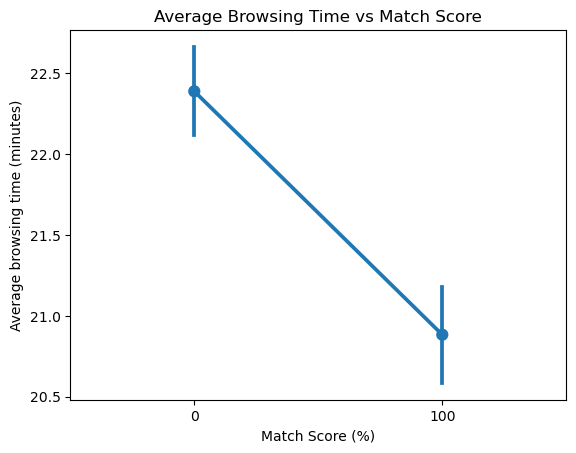

In [36]:
# Main effect of match_score
#sns.set_theme(style="darkgrid")
fig1 = sns.pointplot(x="match_score", y="browse_time", data=data)
fig1.set_ylabel("Average browsing time (minutes)")
fig1.set_xlabel("Match Score (%)")
plt.title("Average Browsing Time vs Match Score")

Text(0.5, 1.0, 'Average Browsing Time vs Preview Length for different Match Scores')

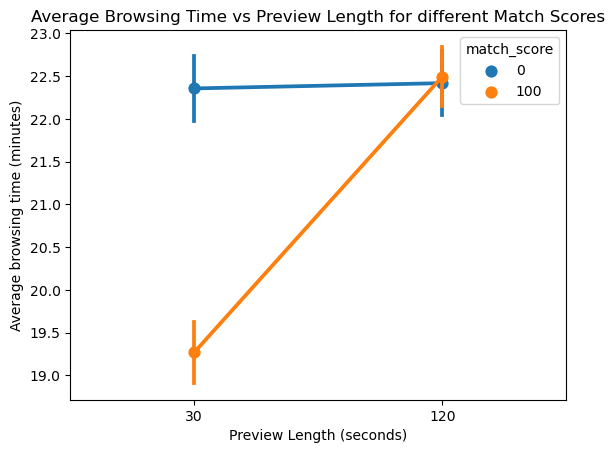

In [37]:
# Interaction between match_score and prev_length
#sns.set_theme(style="darkgrid")
fig12 = sns.pointplot(x="prev_length", hue="match_score", y="browse_time", data=data)
fig12.set_ylabel("Average browsing time (minutes)")
fig12.set_xlabel("Preview Length (seconds)")
plt.title("Average Browsing Time vs Preview Length for different Match Scores")

Here, I observe that when the match score is null, the ABT doesn't seem to be very different for PL=30 and PL=120. This explains why in the summary table, the t-test for PL rejected H0. Since we saw with tests and plots that PL has a significant main effect, we know that what we observed from the summary table is only due to the choice of values for PL. Had I chosen other values, we'd probably have had a rejection of H0 (i.e. significant main effect of PL). Plus, the fact that there's a significant interaction effect between PL and MS implies that PL is significant.

Text(0.5, 1.0, 'Average Browsing Time vs Match Score for different Preview Lengths')

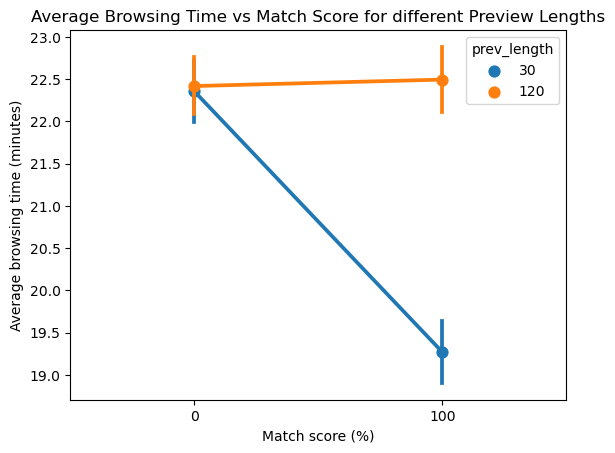

In [41]:
# Interaction between prev_length and match_score (not adding more information to the previous plot)
#sns.set_theme(style="darkgrid")
fig12 = sns.pointplot(x="match_score", hue="prev_length", y="browse_time", data=data)
fig12.set_ylabel("Average browsing time (minutes)")
fig12.set_xlabel("Match score (%)")
plt.title("Average Browsing Time vs Match Score for different Preview Lengths")

Let's now print the distribution of the ABT for each level of one of the design factors Preview Length and Match Score.

Text(0.5, 1.0, 'Average Browsing Time vs Preview Length')

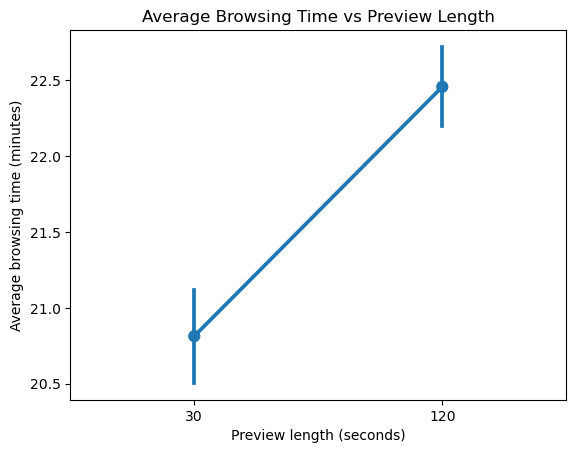

In [42]:
# Main effect of prev_length
#sns.set_theme(style="darkgrid")
fig1 = sns.pointplot(x="prev_length", y="browse_time", data=data)
fig1.set_ylabel("Average browsing time (minutes)")
fig1.set_xlabel("Preview length (seconds)")
plt.title("Average Browsing Time vs Preview Length")

<Axes: xlabel='browse_time', ylabel='Count'>

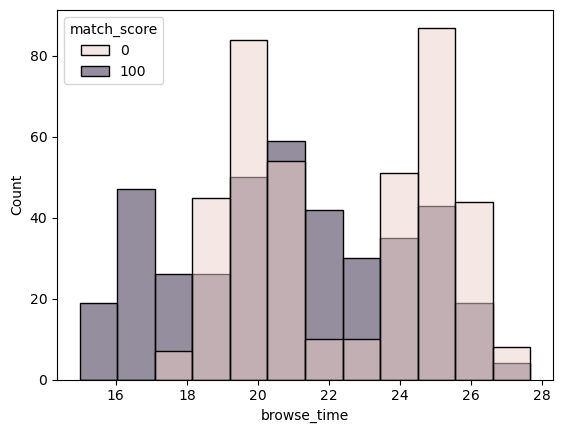

In [43]:
sns.histplot(x="browse_time", hue="match_score", data=data)
plt.vlines(x = np.mean(condition_1), ymin = 0, ymax = 120, color = "red", linewidth = 2)

Here we observe that, even though there's a lot of overlap between the distribution of browsing times when MS=0 and the one when MS=100, the latter is a bit shifted to the right, meaning that when MS=0, BT tend to be larger (not in average though, this is only considering the whole distribution).

<Axes: xlabel='browse_time', ylabel='Count'>

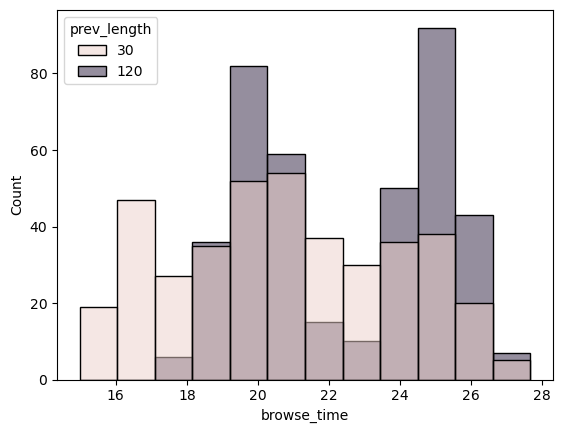

In [44]:
sns.histplot(x="browse_time", hue="prev_length", data=data)

In [ ]:
xmin = min(min(condition_1), min(condition_2))
xmax = max(max(condition_1), max(condition_2))

plt.figure()
plt.hist(condition_1, color = "white", edgecolor = "black")
plt.xlim(xmin,xmax)
plt.xlabel("Minutes Engaged")
plt.ylabel("Frequency")
plt.title("Condition 1")
plt.vlines(x = np.mean(condition_1), ymin = 0, ymax = 120, color = "red", linewidth = 2)

plt.figure()
plt.hist(condition_2, color = "white", edgecolor = "black")
plt.xlim(xmin,xmax)
plt.xlabel("Minutes Engaged")
plt.ylabel("Frequency")
plt.title("Condition 2")
plt.vlines(x = np.mean(condition_2), ymin = 0, ymax = 120, color = "red", linewidth = 2)

In [50]:
condition_1 = data.loc[(data['prev_length']==30) & (data['match_score']==0) & (data['prev_type']=='TT'), 'browse_time']
condition_2 = data.loc[(data['prev_length']==30) & (data['match_score']==100) & (data['prev_type']=='TT'), 'browse_time']
condition_3 = data.loc[(data['prev_length']==120) & (data['match_score']==0) & (data['prev_type']=='TT'), 'browse_time']
condition_4 = data.loc[(data['prev_length']==120) & (data['match_score']==100) & (data['prev_type']=='TT'), 'browse_time']

In [52]:
condition_1.mean()

19.804020155039012

In [56]:
condition_2.mean()

16.782149244985398

In [57]:
condition_3.mean()

19.823611241682073

In [58]:
condition_4.mean()

20.075245454022618

In [59]:
0.05/108

0.000462962962962963

In [64]:
M=108

In [65]:
test_variances(condition_1, condition_2, FWER=0.05 * M, n1=len(condition_1), n2=len(condition_2))

True

In [68]:
test_means(condition_1, condition_2, FWER=0.05 * M, n1=len(condition_1), n2=len(condition_2))

'mu_1 > mu_2'

Condition 2 has a significantly lower average browsing time than condition 1, at a 5% significant level.

## Part 3: second factorial experiment

### Choosing the design factors' levels

In [69]:
# For Preview length

# Generate the sequence
sequence = list(range(30, 101, 5))

# Find five values that are the most spaced from one another
# by selecting values roughly evenly distributed across the range
num_values_to_select = 3
selected_values = []

# Calculate the step size to achieve roughly even distribution
step_size = len(sequence) // (num_values_to_select - 1)

# Select values at intervals of step_size
for i in range(0, len(sequence), step_size):
    selected_values.append(sequence[i])

print("Selected values:", selected_values)

Selected values: [30, 65, 100]


In [73]:
# For Match Score

# Generate the sequence
sequence = list(range(25, 102, 1))

# Find five values that are the most spaced from one another
# by selecting values roughly evenly distributed across the range
num_values_to_select = 3
selected_values = []

# Calculate the step size to achieve roughly even distribution
step_size = len(sequence) // (num_values_to_select - 1)

# Select values at intervals of step_size
for i in range(0, len(sequence), step_size):
    selected_values.append(sequence[i])

print("Selected values:", selected_values)

Selected values: [25, 63, 101]


### Generating the data

In [75]:
def generate_file_for_app(preview_length_levels, match_score_levels):
    # Generate all possible combinations of the design factors' levels
    all_combinations = list(itertools.product(preview_length_levels, match_score_levels))

    # Create a DataFrame
    df = pd.DataFrame(all_combinations, columns=['Prev.Length', 'Match.Score'])

    # Export the DataFrame to a CSV file
    df.to_csv('all_combinations.csv', index=False)

    return df

In [76]:
preview_length_levels = [30, 65, 100]
match_score_levels = [25, 62, 100]
generate_file_for_app(preview_length_levels, match_score_levels)

,Prev.Length,Match.Score
0,30,25
1,30,62
2,30,100
3,65,25
4,65,62
5,65,100
6,100,25
7,100,62
8,100,100


Now, we need to use the produced file in the app.

In [80]:
df = pd.read_csv('RESULTS_EGDGIDAF_CumCondCount=9_2024-01-18.csv')

In [81]:
df.head()

,Prev.Length,Match.Score,Tile.Size,Prev.Type,Browse.Time
0,30,25,0.2,TT,19.911651
1,30,62,0.2,TT,15.998664
2,30,100,0.2,TT,17.437924
3,65,25,0.2,TT,21.162640
4,65,62,0.2,TT,13.453529


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Prev.Length  900 non-null    int64  
 1   Match.Score  900 non-null    int64  
 2   Tile.Size    900 non-null    float64
 3   Prev.Type    900 non-null    object 
 4   Browse.Time  900 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 35.3+ KB


In [83]:
# sanity check
for col in df.columns[:-1]:
    print(f"{col} has {df[col].nunique()} level(s): {df[col].unique()}")

Prev.Length has 3 level(s): [ 30  65 100]
Match.Score has 3 level(s): [ 25  62 100]
Tile.Size has 1 level(s): [0.2]
Prev.Type has 1 level(s): ['TT']


In [84]:
def create_exp_conditions_dict(df):
    exp_conditions_dict = dict()
    for prev_length in preview_length_levels:
        for match_score in match_score_levels:
            condition = f"PL_{prev_length}_MS_{match_score}"
            exp_conditions_dict[condition] = df.loc[(df['Prev.Length']==prev_length) & (df['Match.Score']==match_score), 'Browse.Time']
    return exp_conditions_dict

In [85]:
exp_conditions_dict = create_exp_conditions_dict(df)
exp_conditions_dict.keys()

dict_keys(['PL_30_MS_25', 'PL_30_MS_62', 'PL_30_MS_100', 'PL_65_MS_25', 'PL_65_MS_62', 'PL_65_MS_100', 'PL_100_MS_25', 'PL_100_MS_62', 'PL_100_MS_100'])

### Running the experiments

#### By hand

In [ ]:
t = np.var(exp_conditions['prev_length_30_match_score_50'], ddof=1)/np.var(exp_conditions['prev_length_30_match_score_75'], ddof=1)

print("t =", t)

t = 1.1260174977823592


In [ ]:
pv = stats.f.cdf(1/t, dfn=99, dfd=99) + 1 - stats.f.cdf(t, dfn=99, dfd=99)
print("p-value =", pv)

p-value = 0.5559959237577752


This p-value is so large that we do not reject $H_0:\sigma_1^2=\sigma_2^2$, and so we will use Student's t-test to test hypotheses concerning $\mu_1$ and $\mu_2$.

Note: in theory, also need to check normality. For now, let's assume it's true.

Note: multiple testing problem
Here, we're going to perform M=36 pairwise comparison tests (even if for 2 given hypothesis H0 and H1, we perform the gatekeeper test and the one-sided test, we count those as 1 test). Therefore, using the Bonferroni correction method, and if we choose a FWER of 5%, then we need to compare each p-value to 5%/36, which is:

In [ ]:
M=36

In [ ]:
sign_level = 0.05/M
sign_level

0.001388888888888889

Let us first test $$H_0:\mu_1=\mu_2 \text{ vs. }H_A:\mu_1\neq\mu_2$$, also referred to as the "gatekeeper test".

Note: for now, we'll perform the Bonferroni's correction by hand, because we don't really know in advance all the tests we're going to perform: it depends on the outcomes of previous tests. So we're going to perform those multiple tests sequentially, using M in the worst case scenario, which is 36. Then, we'll count the number of comparisons we **effectively** did, and we'll come back and correct M, and use already existing Bonferroni correction python methods to do the tests again.

In [ ]:
t, pv = stats.ttest_ind(exp_conditions['prev_length_30_match_score_50'],\
                        exp_conditions['prev_length_30_match_score_75'],\
                        equal_var=True, alternative='two-sided')  # we assume that the samples under H0 and H1 are independent
print("t =", t)
print("p-value =", pv)

t = 15.503203146855673
p-value = 5.1453921668628964e-36


The p-value being very small (much smaller than the significant level), we reject H0, suggesting that there's a significant difference in terms of average browsing time between the 2 options.

Next let us test $$H_0:\mu_1\leq\mu_2 \text{ vs. }H_A:\mu_1>\mu_2$$

In [ ]:
t, pv = stats.ttest_ind(exp_conditions['prev_length_30_match_score_50'],\
                        exp_conditions['prev_length_30_match_score_75'],\
                        equal_var=True, alternative='greater')  # we assume that the samples under H0 and H1 are independent
print("t =", t)
print("p-value =", pv)

t = 15.503203146855673
p-value = 2.5726960834314482e-36


This is an extremely small p-value (<<sign.level), providing very strong evidence against the null hypothesis above, suggesting that the average browsing time is significantly larger in the first condition than in the second.

At this point, I know that, for a given preview length of 30 seconds, a match score of 75 is associated with a significantly lower average browsing time than a match score of 50.

Now, instead of comparing prev_length_30_match_score_50 and prev_length_30_match_score_100, let's directly compare 'prev_length_30_match_score_75' and 'prev_length_30_match_score_100', which, depending on the result, and using transitivity, might save us some tests.

Let's first make sure a t-test is suitable to compare those 2 ECs.

In [ ]:
t = np.var(exp_conditions['prev_length_30_match_score_75'], ddof=1)/np.var(exp_conditions['prev_length_30_match_score_100'], ddof=1)

print("t =", t)

t = 1.0076753332820492


In [ ]:
pv = stats.f.cdf(1/t, dfn=99, dfd=99) + 1 - stats.f.cdf(t, dfn=99, dfd=99)
print("p-value =", pv)

p-value = 0.9697335052057174


Fail to reject H0, so a t-test is suitable for comparing those 2 ECs.

In [ ]:
t, pv = stats.ttest_ind(exp_conditions['prev_length_30_match_score_75'],\
                        exp_conditions['prev_length_30_match_score_100'],\
                        equal_var=True, alternative='two-sided')  # we assume that the samples under H0 and H1 are independent
print("t =", t)
print("p-value =", pv)

t = -9.99996974629168
p-value = 2.561533355682028e-19


Significant difference between the 2 groups.

In [ ]:
t, pv = stats.ttest_ind(exp_conditions['prev_length_30_match_score_75'],\
                        exp_conditions['prev_length_30_match_score_100'],\
                        equal_var=True, alternative='greater')  # we assume that the samples under H0 and H1 are independent
print("t =", t)
print("Adjusted p-value =", pv)

t = -9.99996974629168
Adjusted p-value = 1.0


Let's invert the hypothesis for a better interpretation (easier to interprete a rejection than a non-rejection).

In [ ]:
t, pv = stats.ttest_ind(exp_conditions['prev_length_30_match_score_100'],\
                        exp_conditions['prev_length_30_match_score_75'],\
                        equal_var=True, alternative='greater')  # we assume that the samples under H0 and H1 are independent
print("t =", t)
print("Adjusted p-value =", pv)

t = 9.99996974629168
Adjusted p-value = 1.280766677841014e-19


Here, I can reject H0. Surprisingly, for a given prev_length of 30, the average browsing time is significantly longer when the match score is 100% than when it's 75%.

Now, I know that for a given prev_length of 30, out of the 3 values 50, 75 and 100 for the match score, 75 is the one associated with the significantly lowest average browsing time. Unfortunately, this doesn't tell us in which direction to go next. My intuition is to search between 75 and 100 now but it's just my opinion.

I can maybe decide by comparing, for a given prev.length of 30, a match score of 50 and 100.

In [ ]:
t, pv = stats.ttest_ind(exp_conditions['prev_length_30_match_score_50'],\
                        exp_conditions['prev_length_30_match_score_100'],\
                        equal_var=True, alternative='two-sided')  # we assume that the samples under H0 and H1 are independent
print("t =", t)
print("p-value =", pv)

t = 5.833074490457729
p-value = 2.1880084187392873e-08


In [ ]:
t, pv = stats.ttest_ind(exp_conditions['prev_length_30_match_score_50'],\
                        exp_conditions['prev_length_30_match_score_100'],\
                        equal_var=True, alternative='greater')  # we assume that the samples under H0 and H1 are independent
print("t =", t)
print("Adjusted p-value =", pv)

t = 5.833074490457729
Adjusted p-value = 1.0940042093696436e-08


For a given prev_length of 30 seconds, a match score of 50 is associated with a significantly larger browsing time than a match score of 100.

In [ ]:
t = np.var(exp_conditions['prev_length_30_match_score_50'], ddof=1)/np.var(exp_conditions['prev_length_60_match_score_50'], ddof=1)
print("t =", t)

t = 1.0807704050178626


In [ ]:
pv = stats.f.cdf(1/t, dfn=99, dfd=99) + 1 - stats.f.cdf(t, dfn=99, dfd=99)
print("p-value =", pv)

p-value = 0.6999403324715381


Can now use a Student's t-test.

In [ ]:
t, pv = stats.ttest_ind(exp_conditions['prev_length_30_match_score_50'],\
                        exp_conditions['prev_length_60_match_score_50'],\
                        equal_var=True, alternative='two-sided')  # we assume that the samples under H0 and H1 are independent
print("t =", t)
print("p-value =", pv)

t = 35.436338598477455
p-value = 1.170448408694852e-87


In [ ]:
t, pv = stats.ttest_ind(exp_conditions['prev_length_30_match_score_50'],\
                        exp_conditions['prev_length_60_match_score_50'],\
                        equal_var=True, alternative='greater')  # we assume that the samples under H0 and H1 are independent
print("t =", t)
print("p-value =", pv)

t = 35.436338598477455
p-value = 5.85224204347426e-88


For a given match score of 50, a preview length of 60 seconds is associated with a significantly lower average browsing time than a prev_length of 30.

In [ ]:
t = np.var(exp_conditions['prev_length_30_match_score_50'], ddof=1)/np.var(exp_conditions['prev_length_60_match_score_75'], ddof=1)
print("t =", t)

t = 1.1682718451183152


In [ ]:
pv = stats.f.cdf(1/t, dfn=99, dfd=99) + 1 - stats.f.cdf(t, dfn=99, dfd=99)
print("p-value =", pv)

p-value = 0.4404750123597365


In [ ]:
t, pv = stats.ttest_ind(exp_conditions['prev_length_30_match_score_50'],\
                        exp_conditions['prev_length_60_match_score_75'],\
                        equal_var=True, alternative='two-sided')  # we assume that the samples under H0 and H1 are independent
print("t =", t)
print("p-value =", pv)

t = 45.17519288669447
p-value = 3.099794118217261e-106


In [ ]:
t, pv = stats.ttest_ind(exp_conditions['prev_length_30_match_score_50'],\
                        exp_conditions['prev_length_60_match_score_75'],\
                        equal_var=True, alternative='greater')  # we assume that the samples under H0 and H1 are independent
print("t =", t)
print("p-value =", pv)

t = 45.17519288669447
p-value = 1.5498970591086305e-106


The EC 'prev_length_60_match_score_75' is associated with a significantly lower ABT than the EC 'prev_length_30_match_score_50'.

In [ ]:
t = np.var(exp_conditions['prev_length_30_match_score_50'], ddof=1)/np.var(exp_conditions['prev_length_60_match_score_100'], ddof=1)
print("t =", t)

t = 1.1502049383528816


In [ ]:
pv = stats.f.cdf(1/t, dfn=99, dfd=99) + 1 - stats.f.cdf(t, dfn=99, dfd=99)
print("p-value =", pv)

p-value = 0.4875848410054422


In [ ]:
t, pv = stats.ttest_ind(exp_conditions['prev_length_30_match_score_50'],\
                        exp_conditions['prev_length_60_match_score_100'],\
                        equal_var=True, alternative='two-sided')  # we assume that the samples under H0 and H1 are independent
print("t =", t)
print("p-value =", pv)

t = 18.30418757047403
p-value = 1.8749284355507728e-44


In [ ]:
t, pv = stats.ttest_ind(exp_conditions['prev_length_30_match_score_50'],\
                        exp_conditions['prev_length_60_match_score_100'],\
                        equal_var=True, alternative='greater')  # we assume that the samples under H0 and H1 are independent
print("t =", t)
print("p-value =", pv)

t = 18.30418757047403
p-value = 9.374642177753864e-45


The EC 'prev_length_60_match_score_100' is associated with a significantly lower ABT than the EC 'prev_length_30_match_score_50'.

In [ ]:
t = np.var(exp_conditions['prev_length_30_match_score_50'], ddof=1)/np.var(exp_conditions['prev_length_90_match_score_50'], ddof=1)
print("t =", t)

t = 1.1121023570899253


In [ ]:
pv = stats.f.cdf(1/t, dfn=99, dfd=99) + 1 - stats.f.cdf(t, dfn=99, dfd=99)
print("p-value =", pv)

p-value = 0.598095357073203


In [ ]:
t, pv = stats.ttest_ind(exp_conditions['prev_length_30_match_score_50'],\
                        exp_conditions['prev_length_90_match_score_50'],\
                        equal_var=True, alternative='two-sided')  # we assume that the samples under H0 and H1 are independent
print("t =", t)
print("p-value =", pv)

t = 5.3218655628549385
p-value = 2.767989864938801e-07


In [ ]:
t, pv = stats.ttest_ind(exp_conditions['prev_length_30_match_score_50'],\
                        exp_conditions['prev_length_90_match_score_50'],\
                        equal_var=True, alternative='greater')  # we assume that the samples under H0 and H1 are independent
print("t =", t)
print("p-value =", pv)

t = 5.3218655628549385
p-value = 1.3839949324694005e-07


The EC 'prev_length_90_match_score_50' is associated with a significantly lower ABT than the EC 'prev_length_30_match_score_50'.

#### Automation

Let's define a function that will automate all the steps and output the p-values of all the pairwise comparison tests in a dataframe.
Steps:
- For each EC:
    - For each EC other than the current one:
        - Perform the test of equal variance.
        - If no rejection, use Student's t-test. Otherwise, use Welch's test.
        - Perform the gatekeeper test.
        - If rejection, perform the one-sided alternative test to determine which EC is better among the 2 tested, and keep the p-value. Otherwise, stop here and conclude that there's no significant difference between both groups in terms of ABT.

Note: before all this, could perform the F-test that tests the equality of all the means together. Not much surprise will come out of it, but for exhaustivity, we'll do it.

Therefore, for all the following tests, should adjust either the significant level to take into account this number of tests.

Note: also need to check normality before being able to perform Student's t-test or Welch's test. TO DO

Let's first define helper function that, given 2 ECs, the FWER, and the sample sizes, will perform all 3 tests: equal variances, equal means, and depending on the results, means comparisons.

In [88]:
def test_variances(condition_1, condition_2, FWER=0.05, n1=100, n2=100):
    t = np.var(condition_1, ddof=1)/np.var(condition_2, ddof=1)
    if t >= 1:
        pv = stats.f.cdf(1/t, dfn=n1-1, dfd=n2-1) + 1 - stats.f.cdf(t, dfn=n1-1, dfd=n2-1)
    else:
        pv = stats.f.cdf(t, dfn=n1-1, dfd=n2-1) + 1 - stats.f.cdf(1/t, dfn=n1-1, dfd=n2-1)

    equal_val = True  # by default, the 2 samples are assumed to have the same variance
    sign_level = FWER/M
    if pv <= sign_level:
        equal_var = False
    return equal_val

In [89]:
def test_means(condition_1, condition_2, FWER=0.05, n1=100, n2=100):
    # This function will perform either the Student's t-test or the Welch's test, depending on equal_var
    equal_val = test_variances(condition_1, condition_2, FWER, n1, n2)

    # Start with the gatekeeper test
    _, pv_gatekeeper = stats.ttest_ind(condition_1, condition_2, equal_var=equal_val, alternative='two-sided')

    sign_level = FWER/M
    # Depending on the result of the gatekeeper test, decide whether or not to perform the one-sided test
    if pv_gatekeeper > sign_level: # equal means
        result = 'mu_1=mu_2'
    else: # non equal means
        _, pv = stats.ttest_ind(condition_1, condition_2, equal_var=equal_val, alternative='greater')
        if pv <= sign_level:  # reject H0, so mu_1 > mu_2
            result = 'mu_1 > mu_2'
        else:  # fail to reject H0, so we conclude mu_1 < mu_2  # no need for equality since we first perform gatekeeper test
            result = 'mu_1 < mu_2'
    return result

Now that I have a function that can perform the pariwise test for comparing the means (although we should also check normality: TO DO later), I need to store all the results in a dataframe.

In [90]:
def factorial_experiment(exp_conditions_dict):
    # Store the experimental conditions in a list
    exp_conditions = list(exp_conditions_dict.keys())
    # Count the number experimental conditions
    m = len(exp_conditions)
    # Count the number of pairwise comparison tests to perform
    # For each pair of ECs, we'll perform at most 3 tests (and at least 2)
    M = 3 * math.comb(m, 2)

    # Perform all the pairwise tests, and store the results in a dataframe,
    # where the index corresponds to conditions 1 and columns to conditions 2
    results = np.full(shape=(m,m), fill_value='NA', dtype='<U15')

    for i in range(m-1):
        condition_1 = exp_conditions_dict[exp_conditions[i]]
        for j in range(i+1, m):
            condition_2 = exp_conditions_dict[exp_conditions[j]]
            results[i,j] = test_means(condition_1, condition_2)
    results = pd.DataFrame(results, columns=exp_conditions, index=exp_conditions)

    return results

In [91]:
results = factorial_experiment(exp_conditions_dict)
results

,PL_30_MS_25,PL_30_MS_62,PL_30_MS_100,PL_65_MS_25,PL_65_MS_62,PL_65_MS_100,PL_100_MS_25,PL_100_MS_62,PL_100_MS_100
PL_30_MS_25,NA,mu_1 > mu_2,mu_1 > mu_2,mu_1=mu_2,mu_1 > mu_2,mu_1 > mu_2,mu_1 > mu_2,mu_1 > mu_2,mu_1=mu_2
PL_30_MS_62,NA,NA,mu_1 < mu_2,mu_1 < mu_2,mu_1 > mu_2,mu_1 > mu_2,mu_1 < mu_2,mu_1 > mu_2,mu_1 < mu_2
PL_30_MS_100,NA,NA,NA,mu_1 < mu_2,mu_1 > mu_2,mu_1 > mu_2,mu_1 < mu_2,mu_1 > mu_2,mu_1 < mu_2
PL_65_MS_25,NA,NA,NA,NA,mu_1 > mu_2,mu_1 > mu_2,mu_1 > mu_2,mu_1 > mu_2,mu_1 > mu_2
PL_65_MS_62,NA,NA,NA,NA,NA,mu_1 < mu_2,mu_1 < mu_2,mu_1 < mu_2,mu_1 < mu_2
PL_65_MS_100,NA,NA,NA,NA,NA,NA,mu_1 < mu_2,mu_1=mu_2,mu_1 < mu_2
PL_100_MS_25,NA,NA,NA,NA,NA,NA,NA,mu_1 > mu_2,mu_1=mu_2
PL_100_MS_62,NA,NA,NA,NA,NA,NA,NA,NA,mu_1 < mu_2
PL_100_MS_100,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Choosing the "best" conditions

#### Method n°1: ranking based on n°tests "won"

In [104]:
n_test_won_df = pd.DataFrame(data={"EC": exp_conditions_list, "n_tests_won":[0, 5, 4, 0, 8, 6, 2, 6, 1]}).sort_values(by='n_tests_won', ascending=False)
n_test_won_df

,EC,n_tests_won
4,PL_65_MS_62,8
5,PL_65_MS_100,6
7,PL_100_MS_62,6
1,PL_30_MS_62,5
2,PL_30_MS_100,4
6,PL_100_MS_25,2
8,PL_100_MS_100,1
0,PL_30_MS_25,0
3,PL_65_MS_25,0


#### Method n°2: ranking based on metric of interest at each EC

In [95]:
exp_conditions_dict.keys()

dict_keys(['PL_30_MS_25', 'PL_30_MS_62', 'PL_30_MS_100', 'PL_65_MS_25', 'PL_65_MS_62', 'PL_65_MS_100', 'PL_100_MS_25', 'PL_100_MS_62', 'PL_100_MS_100'])

In [96]:
exp_conditions_list = list(exp_conditions_dict.keys())
exp_conditions_list

['PL_30_MS_25',
 'PL_30_MS_62',
 'PL_30_MS_100',
 'PL_65_MS_25',
 'PL_65_MS_62',
 'PL_65_MS_100',
 'PL_100_MS_25',
 'PL_100_MS_62',
 'PL_100_MS_100']

In [101]:
exp_conditions_ABT = []
for ec in exp_conditions_list:
    exp_conditions_ABT.append(exp_conditions_dict[ec].mean())
exp_conditions_ABT

[19.693775869944286,
 16.15723186739691,
 16.914461320988536,
 19.992185266127102,
 13.100661070841578,
 15.05286923251271,
 19.09275626910009,
 14.681714784918087,
 19.441869351608794]

In [103]:
ABT_per_ec_df = pd.DataFrame(data={"EC": exp_conditions_list, "ABT":exp_conditions_ABT}).sort_values(by='ABT')
ABT_per_ec_df

,EC,ABT
4,PL_65_MS_62,13.100661
7,PL_100_MS_62,14.681715
5,PL_65_MS_100,15.052869
1,PL_30_MS_62,16.157232
2,PL_30_MS_100,16.914461
6,PL_100_MS_25,19.092756
8,PL_100_MS_100,19.441869
0,PL_30_MS_25,19.693776
3,PL_65_MS_25,19.992185


In [105]:
n_test_won_df

,EC,n_tests_won
4,PL_65_MS_62,8
5,PL_65_MS_100,6
7,PL_100_MS_62,6
1,PL_30_MS_62,5
2,PL_30_MS_100,4
6,PL_100_MS_25,2
8,PL_100_MS_100,1
0,PL_30_MS_25,0
3,PL_65_MS_25,0


#### Method n°3: CDD with a=3 (requires a preprocessing of the data) (probably the best)

Here, the goal is to analyze the previous table in order to find, **among all the pairs of conditions that are compared**, the one that's optimal (i.e., the one associated with the lowest ABT).

## PART 4: third factorial experiment

### Choosing the design factors' levels

This time, since we don't simply do the cartesian product of the 2 design factors' levels, we can't automate the generation of the different experimental conditions as easily as we did earlier. Let's do it by hand instead.

**WARNING: we still have constraints on the design factors' levels we're allowed to choose. For Match.Score, it must be an integer. For Preview length, is must be a multiple of 5.**

In [109]:
df = pd.read_csv('RESULTS_EGDGIDAF_CumCondCount=13_2024-01-19.csv')

In [110]:
df.head()

,Prev.Length,Match.Score,Tile.Size,Prev.Type,Browse.Time
0,65,88,0.2,TT,11.837002
1,65,75,0.2,TT,11.273734
2,50,68,0.2,TT,13.821253
3,85,68,0.2,TT,12.400004
4,65,88,0.2,TT,12.952182


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Prev.Length  400 non-null    int64  
 1   Match.Score  400 non-null    int64  
 2   Tile.Size    400 non-null    float64
 3   Prev.Type    400 non-null    object 
 4   Browse.Time  400 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 15.8+ KB


In [112]:
# sanity check
for col in df.columns[:-1]:
    print(f"{col} has {df[col].nunique()} level(s): {df[col].unique()}")

Prev.Length has 3 level(s): [65 50 85]
Match.Score has 3 level(s): [88 75 68]
Tile.Size has 1 level(s): [0.2]
Prev.Type has 1 level(s): ['TT']


In [113]:
# sanity check
len(df)

400

Similarly, in order to define the ECs this time, we can't use for loops, as we don't want a cartesian products of all levels, but only a subset of them.

In [114]:
exp_conditions_dict = {
    'PL_65_MS_88': df.loc[(df['Prev.Length']==65) & (df['Match.Score']==88), 'Browse.Time'],
    'PL_65_MS_75': df.loc[(df['Prev.Length']==65) & (df['Match.Score']==75), 'Browse.Time'],
    'PL_50_MS_68': df.loc[(df['Prev.Length']==50) & (df['Match.Score']==68), 'Browse.Time'],
    'PL_85_MS_68': df.loc[(df['Prev.Length']==85) & (df['Match.Score']==68), 'Browse.Time'],
}

In [115]:
exp_conditions_list = list(exp_conditions_dict.keys())
exp_conditions_list

['PL_65_MS_88', 'PL_65_MS_75', 'PL_50_MS_68', 'PL_85_MS_68']

In [116]:
exp_conditions_ABT = []
for ec in exp_conditions_list:
    exp_conditions_ABT.append(exp_conditions_dict[ec].mean())

In [117]:
ABT_per_ec_df = pd.DataFrame(data={"EC": exp_conditions_list, "ABT":exp_conditions_ABT}).sort_values(by='ABT')
ABT_per_ec_df

,EC,ABT
1,PL_65_MS_75,11.011760
3,PL_85_MS_68,11.439318
0,PL_65_MS_88,11.444045
2,PL_50_MS_68,13.844585


## Part 5: CCD

In [238]:
os.chdir("/Users/fredserfati/Desktop/MSDS/Intersession/Project/real_data/Exp_5")

In [239]:
df = pd.read_csv('RESULTS_EGDGIDAF_CumCondCount=22_2024-01-19.csv')
df = df.drop(columns=['Tile.Size', 'Prev.Type']).rename(columns={'Prev.Length':'PL', 'Match.Score':"MS", "Browse.Time":"browse_time"})

In [240]:
df.head()

,PL,MS,browse_time
0,60,80,11.999635
1,65,80,11.325193
2,70,80,10.849619
3,60,75,13.405714
4,65,75,10.773951


In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PL           900 non-null    int64  
 1   MS           900 non-null    int64  
 2   browse_time  900 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 21.2 KB


In [242]:
# sanity check
for col in df.columns[:-1]:
    print(f"{col} has {df[col].nunique()} level(s): {df[col].unique()}")

PL has 3 level(s): [60 65 70]
MS has 3 level(s): [80 75 70]


In [243]:
def convertNtoC(U, UH, UL):
    x = (U - (UH+UL)/2) / ((UH-UL)/2)  
    return x

def convertCtoN(x, UH, UL):
    U = x*(UH-UL)/2 + (UH+UL)/2
    return U

In [244]:
U_H_PL = 70
U_L_PL = 60
U_H_MS = 80
U_L_MS = 70

In [245]:
PL_coded = convertNtoC(U=df['PL'], UH=U_H_PL, UL=U_L_PL)
MS_coded = convertNtoC(U=df['MS'], UH=U_H_MS, UL=U_L_MS)
df['PL'] = PL_coded
df['MS'] = MS_coded

In [246]:
df.groupby(['PL', 'MS'])['browse_time'].mean().sort_values()

PL    MS  
 1.0   0.0    10.569072
      -1.0    10.646380
       1.0    10.807390
 0.0  -1.0    10.894431
       1.0    10.948739
       0.0    11.033618
-1.0   0.0    11.588349
       1.0    11.640677
      -1.0    12.006313
Name: browse_time, dtype: float64

In [247]:
model = smf.ols('browse_time ~ PL + MS + PL:MS + I(PL**2) + I(MS**2)', data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            browse_time   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     41.14
Date:                Thu, 18 Jan 2024   Prob (F-statistic):           3.69e-38
Time:                        19:47:11   Log-Likelihood:                -1246.9
No. Observations:                 900   AIC:                             2506.
Df Residuals:                     894   BIC:                             2535.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.8965      0.072    150.674      0.000      10.755      11.038
PL            -0.5354      0.040    -13.517      0.000      -0.613      -0.458
MS            -0.0251      0.040     -0.632      0.527      -0.103       0.053
PL:MS          0.1317      0.049      2.714      0.007       0.036       0.227
I(PL ** 2)     0.2508      0.069      3.655      0.000       0.116       0.385
I(MS ** 2)     0.0936      0.069      1.365      0.173      -0.041       0.228
==============================================================================
Omnibus:                        1.333   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.514   Jarque-Bera (JB):                1.300
Skew:                          -0.093   Prob(JB):                        0.522
Kurtosis:                       3.002   Cond. No.                         4.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

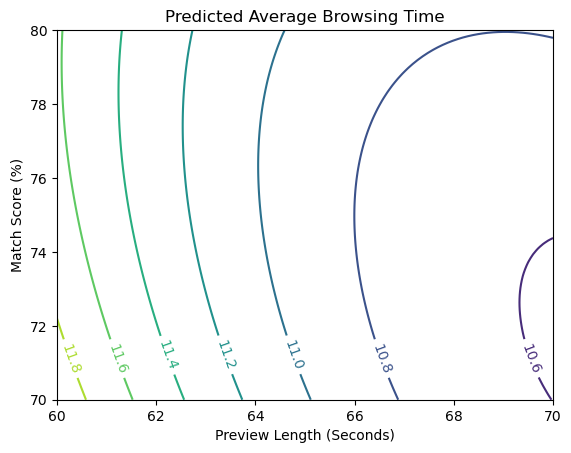

In [248]:
beta0 = model.params[0]
beta1 = model.params[1]
beta2 = model.params[2]
beta12 = model.params[3]
beta11 = model.params[4]
beta22 = model.params[5]
PL, MS = np.meshgrid(np.linspace(convertNtoC(U = 60, UH = U_H_PL, UL = U_L_PL), 
                                 convertNtoC(U = 70, UH = U_H_PL, UL = U_L_PL), 100), 
                     np.linspace(convertNtoC(U = 70, UH = U_H_MS, UL = U_L_MS), 
                                 convertNtoC(U = 80, UH = U_H_MS, UL = U_L_MS), 100))
eta = beta0 + beta1*PL + beta2*MS + beta12*PL*MS + beta11*PL**2 + beta22*MS**2
#pi = np.exp(eta)/(1+np.exp(eta))

h = plt.contour(convertCtoN(PL, UH=U_H_PL, UL=U_L_PL),
                convertCtoN(MS, UH=U_H_MS, UL=U_L_MS), eta)
plt.clabel(h, inline=True, fontsize=10)
plt.xlabel('Preview Length (Seconds)')
plt.ylabel('Match Score (%)')
plt.title('Predicted Average Browsing Time')
plt.show()

In [249]:
b = np.matrix([beta1, beta2]).transpose()
B = np.matrix([[beta11, 0.5*beta12], [0.5*beta12, beta22]])
x_s = -0.5* np.matmul(np.linalg.inv(B), b)
print("ABT is maximized when x1=", x_s[0], "and x2=", x_s[1])

ABT is maximized when x1= [[1.26609621]] and x2= [[-0.75630257]]


In [250]:
xsN_1 = convertCtoN(x = x_s[0], UH = U_H_PL, UL=U_L_PL)
xsN_2 = convertCtoN(x = x_s[1], UH = U_H_MS, UL=U_L_MS)
print("PL=", xsN_1, ", MS=", xsN_2)

PL= [[71.33048106]] , MS= [[71.21848717]]


In [251]:
eta_s = beta0 + 0.5*np.matmul(x_s.transpose(), b)
print(eta_s)

[[10.56703086]]


In [252]:
yhat = model.predict(exog=dict(PL=convertNtoC(U = 70, UH = U_H_PL, UL = U_L_PL), 
                               MS=convertNtoC(U = 71, UH = U_H_MS, UL = U_L_MS)))
print(yhat)

0    10.586497
dtype: float64


Let's now collect data at this **estimated** minimizer and check if the ABT at this EC is close to the estimation.

In [253]:
os.chdir("/Users/fredserfati/Desktop/MSDS/Intersession/Project/real_data/Exp_6")

In [254]:
df_1 = pd.read_csv('RESULTS_EGDGIDAF_CumCondCount=10_2024-01-19.csv').rename(columns={'Prev.Length':'PL', 'Match.Score':"MS", "Browse.Time":"browse_time"})

In [255]:
df_1.head()

,PL,MS,Tile.Size,Prev.Type,browse_time
0,70,71,0.2,TT,10.637966
1,70,71,0.2,TT,12.131660
2,70,71,0.2,TT,11.163998
3,70,71,0.2,TT,10.426880
4,70,71,0.2,TT,8.175595


In [256]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PL           100 non-null    int64  
 1   MS           100 non-null    int64  
 2   Tile.Size    100 non-null    float64
 3   Prev.Type    100 non-null    object 
 4   browse_time  100 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 4.0+ KB


In [258]:
df_1['browse_time'].mean()

10.474258152754363

In [259]:
df_1['browse_time']

0     10.637966
1     12.131660
2     11.163998
3     10.426880
4      8.175595
        ...    
95     9.538950
96    10.009106
97    10.589368
98     9.445053
99     9.590121
Name: browse_time, Length: 100, dtype: float64

(array([ 3.,  5., 11., 23., 29., 14.,  5.,  7.,  1.,  2.]),
 array([ 7.90421895,  8.48928883,  9.07435871,  9.65942859, 10.24449848,
        10.82956836, 11.41463824, 11.99970813, 12.58477801, 13.16984789,
        13.75491777]),
 <BarContainer object of 10 artists>)

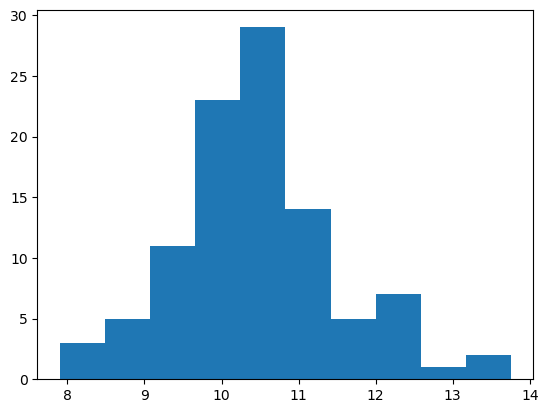

In [295]:
plt.hist(df_1['browse_time'])

In [297]:
alpha = 0.05
sample = df_1['browse_time']
n = len(sample)
x_bar = sample.mean()
s = np.sqrt(np.var(sample, ddof=1))
critical_value = stats.t.ppf(q=1-alpha/2, df=n-1)
lower_bound = x_bar - (s/np.sqrt(n)) * critical_value
upper_bound = x_bar + (s/np.sqrt(n)) * critical_value
print(lower_bound, upper_bound)

10.264531512189762 10.683984793318963


### Part 6: second CDD

In [261]:
df_2 = pd.read_csv('RESULTS_EGDGIDAF_CumCondCount=18_2024-01-19.csv')
df_2 = df_2.drop(columns=['Tile.Size', 'Prev.Type']).rename(columns={'Prev.Length':'PL', 'Match.Score':"MS", "Browse.Time":"browse_time"})

In [262]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PL           800 non-null    int64  
 1   MS           800 non-null    int64  
 2   browse_time  800 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 18.9 KB


In [276]:
df_3 = pd.concat([df_1, df_2]).drop(columns=['Tile.Size', 'Prev.Type'])

In [277]:
df_3

,PL,MS,browse_time
0,70,71,10.637966
1,70,71,12.131660
2,70,71,11.163998
3,70,71,10.426880
4,70,71,8.175595
...,...,...,...
795,70,76,9.289558
796,70,66,11.098839
797,75,76,8.366348
798,75,71,10.989900


In [278]:
U_H_PL = 75
U_L_PL = 65
U_H_MS = 76
U_L_MS = 66

In [279]:
PL_coded = convertNtoC(U=df_3['PL'], UH=U_H_PL, UL=U_L_PL)
MS_coded = convertNtoC(U=df_3['MS'], UH=U_H_MS, UL=U_L_MS)
df_3['PL'] = PL_coded
df_3['MS'] = MS_coded

In [280]:
df_3

,PL,MS,browse_time
0,0.0,0.0,10.637966
1,0.0,0.0,12.131660
2,0.0,0.0,11.163998
3,0.0,0.0,10.426880
4,0.0,0.0,8.175595
...,...,...,...
795,0.0,1.0,9.289558
796,0.0,-1.0,11.098839
797,1.0,1.0,8.366348
798,1.0,0.0,10.989900


In [281]:
df_3.groupby(['PL', 'MS'])['browse_time'].mean().sort_values()

PL    MS  
 1.0   1.0     9.931707
       0.0    10.186262
 0.0   0.0    10.474258
       1.0    10.618234
 1.0  -1.0    10.777336
-1.0   0.0    10.882319
       1.0    10.939379
 0.0  -1.0    10.985734
-1.0  -1.0    11.640132
Name: browse_time, dtype: float64

In [282]:
model = smf.ols('browse_time ~ PL + MS + PL:MS + I(PL**2) + I(MS**2)', data = df_3).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            browse_time   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     34.96
Date:                Thu, 18 Jan 2024   Prob (F-statistic):           1.02e-32
Time:                        19:54:01   Log-Likelihood:                -1310.9
No. Observations:                 900   AIC:                             2634.
Df Residuals:                     894   BIC:                             2663.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.4920      0.078    135.123      0.000      10.340      10.644
PL            -0.4278      0.043    -10.058      0.000      -0.511      -0.344
MS            -0.3190      0.043     -7.500      0.000      -0.402      -0.236
PL:MS         -0.0362      0.052     -0.695      0.487      -0.138       0.066
I(PL ** 2)     0.0334      0.074      0.454      0.650      -0.111       0.178
I(MS ** 2)     0.3011      0.074      4.088      0.000       0.157       0.446
==============================================================================
Omnibus:                        0.056   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.972   Jarque-Bera (JB):                0.014
Skew:                          -0.002   Prob(JB):                        0.993
Kurtosis:                       3.019   Cond. No.                         4.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

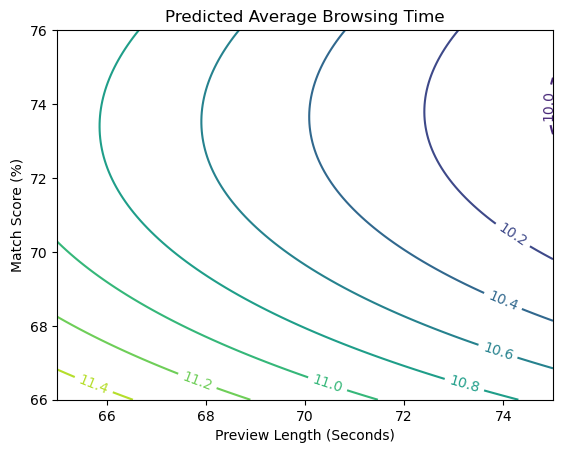

In [283]:
beta0 = model.params[0]
beta1 = model.params[1]
beta2 = model.params[2]
beta12 = model.params[3]
beta11 = model.params[4]
beta22 = model.params[5]
PL, MS = np.meshgrid(np.linspace(convertNtoC(U = 65, UH = U_H_PL, UL = U_L_PL), 
                                 convertNtoC(U = 75, UH = U_H_PL, UL = U_L_PL), 100), 
                     np.linspace(convertNtoC(U = 66, UH = U_H_MS, UL = U_L_MS), 
                                 convertNtoC(U = 76, UH = U_H_MS, UL = U_L_MS), 100))
eta = beta0 + beta1*PL + beta2*MS + beta12*PL*MS + beta11*PL**2 + beta22*MS**2

h = plt.contour(convertCtoN(PL, UH=U_H_PL, UL=U_L_PL),
                convertCtoN(MS, UH=U_H_MS, UL=U_L_MS), eta)
plt.clabel(h, inline=True, fontsize=10)
plt.xlabel('Preview Length (Seconds)')
plt.ylabel('Match Score (%)')
plt.title('Predicted Average Browsing Time')
plt.show()

In [284]:
b = np.matrix([beta1, beta2]).transpose()
B = np.matrix([[beta11, 0.5*beta12], [0.5*beta12, beta22]])
x_s = -0.5* np.matmul(np.linalg.inv(B), b)
print("ABT is maximized when x1=", x_s[0], "and x2=", x_s[1])

ABT is maximized when x1= [[6.9061179]] and x2= [[0.94493133]]


In [285]:
xsN_1 = convertCtoN(x = x_s[0], UH = U_H_PL, UL=U_L_PL)
xsN_2 = convertCtoN(x = x_s[1], UH = U_H_MS, UL=U_L_MS)
print("PL=", xsN_1, ", MS=", xsN_2)

PL= [[104.53058951]] , MS= [[75.72465664]]


In [286]:
eta_s = beta0 + 0.5*np.matmul(x_s.transpose(), b)
print(eta_s)

[[8.86421386]]


In [287]:
yhat = model.predict(exog=dict(PL=convertNtoC(U = 105, UH = U_H_PL, UL = U_L_PL), 
                               MS=convertNtoC(U = 76, UH = U_H_MS, UL = U_L_MS)))
print(yhat)

0    8.865235
dtype: float64


In [288]:
os.chdir("/Users/fredserfati/Desktop/MSDS/Intersession/Project/real_data/Exp_8")

In [289]:
df_4 = pd.read_csv('RESULTS_EGDGIDAF_CumCondCount=19_2024-01-19.csv')

In [291]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Prev.Length  100 non-null    int64  
 1   Match.Score  100 non-null    int64  
 2   Tile.Size    100 non-null    float64
 3   Prev.Type    100 non-null    object 
 4   Browse.Time  100 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 4.0+ KB


In [292]:
df_4.head()

,Prev.Length,Match.Score,Tile.Size,Prev.Type,Browse.Time
0,105,76,0.2,TT,16.094857
1,105,76,0.2,TT,17.477323
2,105,76,0.2,TT,16.376218
3,105,76,0.2,TT,17.026304
4,105,76,0.2,TT,16.611742


In [294]:
df_4['Browse.Time'].mean()

16.714804645395347